# Objectives

- Deep dive into RNN and LSTM computations
- Build LSTM models for Text Classification & Summarization

# Setup

In [3]:
import numpy as np
import pandas as pd
import tensorflow as tf

2024-08-26 09:41:01.269815: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


# RNN

So far, the model we have built on top of learned embeddings is a simple pooling. However, this minimal model fails to capture the sequential nature of text data. We begin our journey of explictly incorporating the sequential nature of text data by looking at recurrent neural networks (RNNs).

If we use dense layers in a feed forward network, say of 2 units, to represent a sequence each of these two units is looking at all the input units as if they were *independent*. However, this assumption is not true for a sequence of text that has a causal relationship between a word and its next word. This sequential nature is better captured through a recurrence relationship depicted in the below figure.

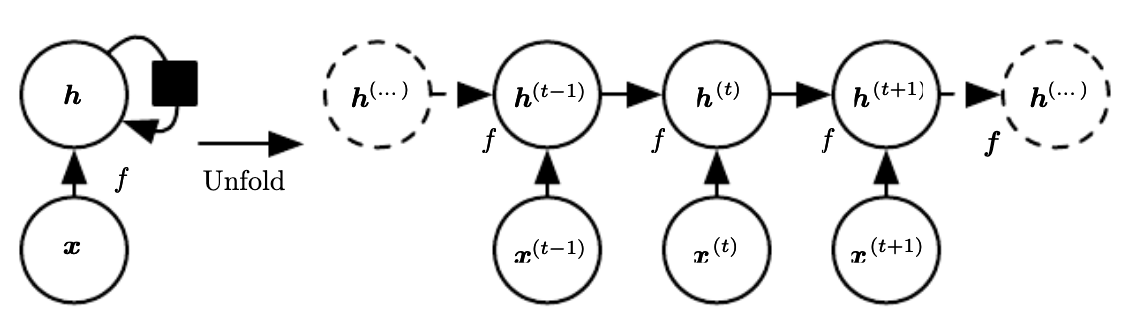

(Source: https://www.deeplearningbook.org/contents/rnn.html)

The figure above depicts the operation of a single RNN unit. It holds a hidden state that captures the representation of the input sequence very much like a unit in a dense layer. Now, imagine dragging this RNN unit through each of the words in the input sequence (i.e., it can be unfolded unlike a unit in a dense layer). For example, as the RNN unit reaches the the second word in the sequence, its hidden state is $\textbf{h}_2$. It receives two inputs to estimate this hidden state. The hidden state that it computed from the first word $\textbf{h}_1$ and the embedding of the current word ($\textbf{x}_2$). It updates the hidden state $\textbf{h}_1$ to $\textbf{h}_2$ (according to the formulae mentioned below), drags this hidden state to the third word, and updates the hidden state according to the same formula. 

Put another way, assume we have a RNN layer of 16 units. When we drag this collection of 16 RNN units along a sequence, a 16-dimensonal message vector is updated during this traversal in parallel across the sequence, word by word. Each unit updates its hidden state by looking at both the message coming from the previous word and the current word embedding. 

So, while units in dense layers treat each input word as independent, units in a RNN layer treat each input word having a direct causal relationship with the next input word.

$\textbf{h}_t = \text{activation}(\textbf{U} \cdot \textbf{h}_{t-1} + \textbf{W} \cdot \textbf{x}_t + b_h)$

where: $\textbf{W} \in \mathbb{R}^{d_h \times d_{in}}$, $\textbf{U} \in \mathbb{R}^{d_h \times d_h}$

$d_{in}$ is the dimensionality of the input tokens and $d_h$ is the dimensionality of the hidden layer defined by the RNN.


In order to understand the above recurrence relation clearly, let us assume we set the hidden state dimension to be 16. This means that a collection of 16 RNN units will transmit a 16-dimensional vector from word to word along the sequence as a message. Consider word 3. This word gets a 16-dimensional vector $\textbf{h}_2$. Word 3 retains a representation of this message as $\textbf{U} \cdot \textbf{h}_2$ and a projection of its own embedding into the hidden dimension $\textbf{W} \cdot \textbf{x}_3$ to generate its updated hidden state. By multiplying $\textbf{h}_2$ with the matrix $\textbf{U}$, word 3 learns how much of the downstream information it needs to retain into its own representation.

Note that the same recurrence function is applied for all the time steps.

Let us now implement a RNN in code and look at its parameters. 

In [4]:
input_sequences = [
    "I like eggs and ham.",
    "I love chocolate and bunnies.",
    "I hate onions.",
    "I like dogs.",
    "I like cats."
]

vectorizer = tf.keras.layers.TextVectorization(
    max_tokens=25,
    output_sequence_length=4
)

text_ds = tf.data.Dataset.from_tensor_slices(input_sequences)
vectorizer.adapt(text_ds)

print(f"Vocabulary size: {len(vectorizer.get_vocabulary())}")

embedding_layer = tf.keras.layers.Embedding(
    len(vectorizer.get_vocabulary()),
    100,
    trainable=True
)

x_train = vectorizer(np.array([[s] for s in input_sequences])).numpy()

embedded_sequences = embedding_layer(x_train)

Vocabulary size: 14


In the above code, we start with a sample of 5 sequences that passes through a vectorization layer and then through an embedding.  

In [5]:
x_train.shape

(5, 4)

In [6]:
embedded_sequences.shape

TensorShape([5, 4, 100])

At this point, we have a batch of 5 sequences, each sequence with 4 words and each word embedded in 100 dimensions. 

In [7]:
simple_rnn = tf.keras.layers.SimpleRNN(16)

output = simple_rnn(embedded_sequences)

The above code creates a RNN layer with 16 units, and hence when we pass a sequence of shape (5, 4, 100) through this layer, the output from this layer is (5, 16). This is because we are collecting only the final hidden state of each unit after it has slid through each word in the input sequences. In essence we created 16 features for each of the 5 sequences aggregating information from the 4 words in each sequence. Each of these features explicitly capture the causal relationship between the words in the sequences.

In [8]:
output.shape

TensorShape([5, 16])

Let us now assemble a model so we can count the parameters of the RNN.

In [9]:
tf.keras.backend.clear_session()
int_sequences_input = tf.keras.Input(shape=(None,), dtype="int32")
embedded_sequences = embedding_layer(int_sequences_input)
simple_rnn = tf.keras.layers.SimpleRNN(16)
hidden_output = simple_rnn(embedded_sequences)
model = tf.keras.Model(int_sequences_input, hidden_output)

In [10]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None)]            0         
                                                                 
 embedding (Embedding)       (None, None, 100)         1400      
                                                                 
 simple_rnn (SimpleRNN)      (None, 16)                1872      
                                                                 
Total params: 3272 (12.78 KB)
Trainable params: 3272 (12.78 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


The mini model presented above passes the input sequences (post text vectorization) through the embedding layer and then on through a RNN layer with 16 units. Since the embedding dimension is 100, we need to learn a word embedding projection matrix ($\textbf{W}$) with $100 \times 16$ parameters and a hidden-state matrix ($\textbf{U}$) of $16 \times 16$ parameters. We also have 16 bias terms for the full recurrence relationship as depicted in the formula above.

In [11]:
print(f"Embedding matrix parameters: {len(vectorizer.get_vocabulary()) * 100}")
print(f"Simple RNN parameters: {16 * 100 + 16 * 16 + 16}")

Embedding matrix parameters: 1400
Simple RNN parameters: 1872


When we now pass our original sample of 5 sequences through this model, we should get out the representations of these 5 sequences in 16 dimensions each. 

In [12]:
model.predict(x_train)

1/1 [==============================] - 0s 165ms/step


array([[ 2.26131063e-02,  5.10874242e-02,  2.71698050e-02,
        -9.20951590e-02,  6.13140166e-02,  3.48539315e-02,
         4.35945354e-02, -5.01366146e-02,  7.50451609e-02,
         3.39968018e-02, -7.26942420e-02, -1.59128353e-01,
         1.91355105e-02, -1.28800049e-01, -9.86287817e-02,
         3.46320379e-03],
       [-7.04153627e-02, -3.01285163e-02,  2.68128403e-02,
        -6.44603372e-03,  1.21503316e-01,  3.78278643e-02,
         4.56266291e-02, -3.69813852e-02, -6.99393675e-02,
         1.85588785e-02, -4.09575365e-03, -7.01957643e-02,
        -1.55510509e-03,  2.67844200e-02, -3.24046165e-02,
        -1.12186754e-02],
       [-3.88665497e-02, -6.08202145e-02,  1.04489826e-01,
        -8.01275596e-02, -3.87640297e-02,  3.61143053e-02,
        -3.59956063e-02,  5.62965833e-02, -4.87217568e-02,
        -2.48288721e-01,  3.73832881e-05, -2.38934115e-01,
        -4.44634967e-02, -5.40628992e-02, -5.11264801e-03,
         6.03275560e-02],
       [ 1.02950841e-01, -1.12420972e

While the default RNN configuration is to output only the last hidden state after the RNN units have traversed the entire sequence, multiple RNN layers could be chained like so:

In [13]:
tf.keras.backend.clear_session()

int_sequences_input = tf.keras.Input(shape=(None,), dtype="int32")
embedded_sequences = embedding_layer(int_sequences_input)

simple_rnn = tf.keras.layers.SimpleRNN(16, return_sequences=True)
hidden_output1 = simple_rnn(embedded_sequences)

simple_rnn = tf.keras.layers.SimpleRNN(36)
hidden_output2 = simple_rnn(hidden_output1)

model = tf.keras.Model(int_sequences_input, hidden_output2)

The difference from before is that when we say `return_sequences=True`, not only the last hidden state but all the hidden states associated with the words in the sequences are returned. This allows chaining of RNNs where the hidden states from the words are passed on to the next layer. Tracing shapes, the input sequence after vectorization of shape `(5 ,4)` passes through the embedding layer and the output is of shape `(5, 4, 100)` (each word is embedded in a 100 dimensional space). This then passes through the first RNN layer and generates an output of `(5, 4, 16)` since there are 16 units in this RNN layer and we return the hidden states of all the 4 words in the sequence. This then passes through another RNN layer with 36 units, so the final output from this layer is `(5, 36)` since we do not return individual hidden states in this layer.  

In [15]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None)]            0         
                                                                 
 embedding (Embedding)       (None, None, 100)         1400      
                                                                 
 simple_rnn (SimpleRNN)      (None, None, 16)          1872      
                                                                 
 simple_rnn_1 (SimpleRNN)    (None, 36)                1908      
                                                                 
Total params: 5180 (20.23 KB)
Trainable params: 5180 (20.23 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


A more complete model can further project the output from the RNN using a dense layer for classification like before.

In [20]:
dataset_path = 'labeled_sentiments_data.tsv'

dataset = pd.read_csv(dataset_path, sep='\t')

sample_dataset = dataset.sample(1000)

reviews = sample_dataset.review
targets = sample_dataset.sentiment

vectorizer = tf.keras.layers.TextVectorization(
    max_tokens=20000,
    output_sequence_length=200
)

text_ds = tf.data.Dataset.from_tensor_slices(reviews).batch(128)

vectorizer.adapt(text_ds)

x_train = vectorizer(np.array([[s] for s in reviews])).numpy()
y_train = np.array(targets)

embedding_layer = tf.keras.layers.Embedding(
    len(vectorizer.get_vocabulary()),
    100,
    trainable=True
)

int_sequences_input = tf.keras.Input(shape=(None,), dtype="int32")

embedded_sequences = embedding_layer(int_sequences_input)

simple_rnn = tf.keras.layers.SimpleRNN(16, return_sequences=True)
hidden_output1 = simple_rnn(embedded_sequences)

simple_rnn = tf.keras.layers.SimpleRNN(36)
hidden_output2 = simple_rnn(hidden_output1)

output_generation = tf.keras.layers.Dense(units=1, activation='sigmoid')(hidden_output2)
model = tf.keras.Model(inputs=int_sequences_input, outputs=output_generation)

model.compile(
    loss="binary_crossentropy", optimizer="rmsprop", metrics=["acc"]
)

We can now train this model for sentiment as we did through the simple pooling model in the previous session.

In [21]:
model.fit(
    x_train, y_train,
    batch_size=128,
    epochs=10,
    validation_split=0.2
)

Epoch 1/10
7/7 [==============================] - 3s 181ms/step - loss: 0.7134 - acc: 0.4787 - val_loss: 0.7138 - val_acc: 0.5400
Epoch 2/10
7/7 [==============================] - 1s 131ms/step - loss: 0.5612 - acc: 0.7150 - val_loss: 0.7901 - val_acc: 0.4300
Epoch 3/10
7/7 [==============================] - 1s 132ms/step - loss: 0.4024 - acc: 0.8225 - val_loss: 0.8268 - val_acc: 0.4350
Epoch 4/10
7/7 [==============================] - 1s 137ms/step - loss: 0.2808 - acc: 0.8988 - val_loss: 0.9382 - val_acc: 0.4350
Epoch 5/10
7/7 [==============================] - 1s 154ms/step - loss: 0.1360 - acc: 0.9712 - val_loss: 0.9543 - val_acc: 0.4650
Epoch 6/10
7/7 [==============================] - 1s 131ms/step - loss: 0.0695 - acc: 0.9937 - val_loss: 1.0766 - val_acc: 0.4450
Epoch 7/10
7/7 [==============================] - 1s 151ms/step - loss: 0.0389 - acc: 0.9975 - val_loss: 1.0843 - val_acc: 0.4650
Epoch 8/10
7/7 [==============================] - 1s 126ms/step - loss: 0.0202 - acc: 1.00

The output above shows clear signs of overfitting where the training accuracy has reached 1.0 while validation accuracy is stuck around 0.44.

# LSTM

While RNN's are an improvement over a dense layer through an explict incorporation of sequential information through hidden states, they still suffer from transmission loss over long sequences due to the repeated function compositions that defines the computation of the RNN unit hidden states.

Long Short-Term Memory (LSTM) networks improve this by reformulating the computation of the RNN cell and adding several gates to conntrol how the unit processes its input, its embedding and its output.

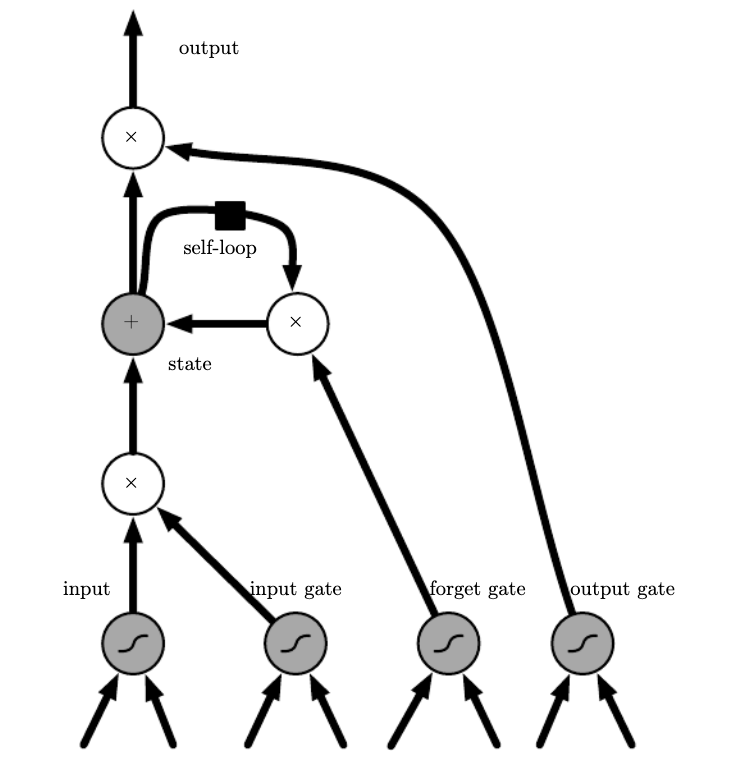

(Source: https://www.deeplearningbook.org/contents/rnn.html)

**Forget gate:**

$\textbf{f}_t = \sigma(\textbf{U}_f \cdot \textbf{h}_{t-1} + \textbf{W}_f \cdot \textbf{x}_t  + b_f)$

**Input gate:**

$\textbf{i}_t = \sigma(\textbf{U}_i \cdot \textbf{h}_{t-1} + \textbf{W}_i \cdot \textbf{x}_t  + b_i)$

$\textbf{g}_t = \tanh(\textbf{U}_g \cdot \textbf{h}_{t-1} + \textbf{W}_g \cdot \textbf{x}_t  + b_g)$

**Add Gate:**

$\textbf{c}_t = \mathbf{f}_t * \mathbf{c}_{t-1} + \mathbf{i}_t * \mathbf{g}_t$

**Output gate:**

$\textbf{o}_t = \tanh(\textbf{U}_o \cdot \textbf{h}_{t-1} + \textbf{W}_o \cdot \textbf{x}_t  + b_o)$

$h_t = \textbf{o}_t * \tanh(\mathbf{c}_t)$



Here: $\mathbf{f}_t * \mathbf{c}_{t-1}$ represents the retained portion of the cell state, while $\mathbf{i}_t * \mathbf{g}_t$ represents the new information that is be added to the cell state. Note that $\sigma$ squishes the input to the region $(0, 1)$ while $\tanh$ constrains the range to $(-1, 1)$.

LSTM networks introduce three key gates—input gate, forget gate, and output gate—to control the flow of information and effectively manage long-term dependencies. These gates are what set LSTM apart from traditional RNNs.

1. Forget Gate:

Purpose: Determines which information should be discarded from the cell state.

How it Helps: The forget gate allows the LSTM to remove information that is no longer relevant to the sequence. This selective forgetting helps prevent the network from being overwhelmed by irrelevant past information, mitigating the vanishing gradient problem.

2. Input Gate:

Purpose: Controls how much of the new information from the current input should be added to the cell state.

How it Helps: The input gate allows the LSTM to add new, relevant information to the cell state. This selective addition ensures that the cell state evolves based on the current context while preserving important long-term dependencies.

3. Output Gate:

Purpose: Decides how much of the cell state should be exposed to the hidden state, effectively controlling the output at each time step.

How it Helps: The output gate allows the LSTM to decide what information should be output at each time step, ensuring that only the relevant parts of the memory (cell state) are used for generating the hidden state.

Cell State: The LSTM's Memory

At the core of the LSTM is the cell state ($\textbf{c}_t$), which acts as a memory that is passed through the network with minimal modifications. The gates (forget and input) control what is added to or removed from the cell state at each time step. This design allows the LSTM to maintain a more consistent memory over long sequences, effectively addressing the long-term dependency problem.

Intuition Behind the Gates

Forget Gate: Imagine reading a long document. As you move through paragraphs, you might choose to forget certain details that are no longer relevant, focusing only on the main points. The forget gate does something similar by allowing the LSTM to forget irrelevant information from the past.

Input Gate: As you read, you continuously update your understanding with new information. The input gate allows the LSTM to selectively add new relevant information to its memory.

Output Gate: Finally, as you summarize what you've read, you focus on the most important points. The output gate controls what information from the LSTM's memory should influence its current output.

Let us implement a LSTM to replace the RNN units we introduced in the previous section.

In [22]:
input_sequences = [
    "I like eggs and ham.",
    "I love chocolate and bunnies.",
    "I hate onions.",
    "I like dogs.",
    "I like cats."
]

vectorizer = tf.keras.layers.TextVectorization(
    max_tokens=25,
    output_sequence_length=4
)

text_ds = tf.data.Dataset.from_tensor_slices(input_sequences)
vectorizer.adapt(text_ds)

print(f"Vocabulary size: {len(vectorizer.get_vocabulary())}")

embedding_layer = tf.keras.layers.Embedding(
    len(vectorizer.get_vocabulary()),
    100,
    trainable=True
)

x_train = vectorizer(np.array([[s] for s in input_sequences])).numpy()

embedded_sequences = embedding_layer(x_train)

Vocabulary size: 14


In [23]:
x_train.shape

(5, 4)

In [24]:
embedded_sequences.shape

TensorShape([5, 4, 100])

One way of creating a LSTM layer that reinforces the fact that it is a special kind of RNN is like so: 

In [26]:
simple_lstm = tf.keras.layers.RNN(tf.keras.layers.LSTMCell(16))

output = simple_lstm(embedded_sequences)

In [27]:
output.shape

TensorShape([5, 16])

Notice how the output shape is exactly the same as it was from a vanilla RNN. This is because while the computation of the cell state is an added overhead, and the hidden state computation is different, the overall method through which RNN layers work is unchanged. Each unit slides over the words in the sequences updating its hidden state according to the LSTM formula and the final hidden state is returned by the unit. 

A simpler way to instantiate an LSTM is like so:

In [28]:
simple_lstm = tf.keras.layers.LSTM(16)

output = simple_lstm(embedded_sequences)

In [29]:
output.shape

TensorShape([5, 16])

Let us now assemble a small LSTM layer so we can count the parameters of the layer.

In [30]:
tf.keras.backend.clear_session()
int_sequences_input = tf.keras.Input(shape=(None,), dtype="int32")
embedded_sequences = embedding_layer(int_sequences_input)
simple_lstm = tf.keras.layers.LSTM(16)
hidden_output = simple_lstm(embedded_sequences)
model = tf.keras.Model(int_sequences_input, hidden_output)

In [31]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None)]            0         
                                                                 
 embedding (Embedding)       (None, None, 100)         1400      
                                                                 
 lstm (LSTM)                 (None, 16)                7488      
                                                                 
Total params: 8888 (34.72 KB)
Trainable params: 8888 (34.72 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


Looking at the LSTM formula above, we note that we have 4 times the parameters of the vanilla RNN because we manage 4 different $\textbf{W}$'s and four different $\textbf{U}$'s to manage the nuanced gating mechanism of the LSTM.

In [31]:
print(f"Embedding matrix parameters: {len(vectorizer.get_vocabulary()) * 100}")
print(f"Simple LSTM parameters: {4 * (100 * 16 + 16 * 16 + 16)}")

Embedding matrix parameters: 1400
Simple LSTM parameters: 7488


The output shape from the LSTM model however is the same as that from a vanilla RNN. 

In [32]:
model.predict(x_train)

1/1 [==============================] - 0s 470ms/step


array([[ 4.53264313e-03,  3.60688544e-03, -3.92293697e-03,
        -7.36268004e-04, -2.08624844e-02,  5.88821340e-03,
        -3.17499898e-02,  1.05169760e-02, -2.27251742e-02,
        -9.45310574e-04, -4.23057843e-03,  1.95509382e-02,
        -3.26968846e-03, -9.46878106e-04, -8.85969773e-03,
        -1.16256662e-02],
       [-6.96956366e-03, -4.08669887e-03,  1.44087523e-03,
         5.37936063e-03, -1.20823253e-02,  2.64162151e-03,
        -1.79347117e-02,  1.11108711e-02, -2.57070512e-02,
        -1.41486768e-02, -1.31487828e-02,  2.13878788e-03,
         1.03083951e-02, -9.10216942e-03,  8.46531056e-03,
        -6.42342679e-03],
       [-1.23176621e-02, -8.55170004e-03,  7.90845975e-03,
        -1.45741440e-02,  8.81683175e-03, -5.33518195e-03,
         3.95028153e-03,  6.99912012e-03,  4.45758319e-03,
         5.11554675e-03, -1.34243276e-02, -2.91397981e-02,
         2.92365393e-03, -1.97790563e-03,  9.74070001e-03,
        -1.40337395e-02],
       [-1.84300006e-03, -6.16494846e

# Bi-directional LSTM

A further improvement over the LSTM we introduced in the previous section is the bi-directional LSTM where we manage two recurrence relationships. One runs from the first word to the last in the sequence and the second runs from the last word to the first (see figure below).

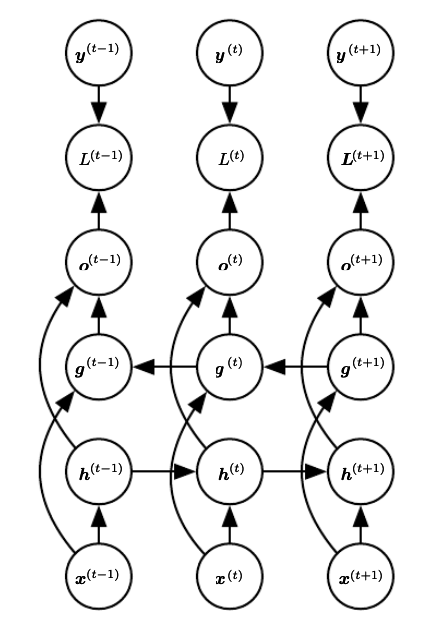

(Source: https://www.deeplearningbook.org/contents/rnn.html)

Bidirectional LSTMs improve upon unidirectional LSTMs by allowing the model to have access to both past (left context) and future (right context) information at each point in the sequence. This bidirectional flow of information helps the model to better capture the dependencies within the data, leading to more accurate and contextually aware outputs.

In a traditional unidirectional LSTM, information flows in only one direction: from the past to the future. At each time step, the LSTM processes the input sequence from left to right, updating its hidden states and cell states based on the previous hidden state and the current input. This means that the output at each time step is influenced only by the inputs that have already been processed (i.e., those that came before the current input in the sequence).

Bidirectional LSTMs address this limitation by incorporating two separate LSTMs: one that processes the input sequence from left to right (forward LSTM) and another that processes it from right to left (backward LSTM). The outputs of these two LSTMs are then combined, typically by concatenating them, to form the final output.

Workflow of a bidirectional LSTM:

Forward LSTM: This LSTM reads the sequence in the standard left-to-right direction, just like a unidirectional LSTM. It generates a hidden state sequence that is based on the past context.

Backward LSTM: This LSTM reads the sequence in the reverse direction, from right to left. It generates a hidden state sequence based on the future context.

Concatenation: At each time step, the hidden states from both the forward and backward LSTMs are concatenated. This combined representation is richer because it encodes information from both the past and the future relative to the current position in the sequence.

Let us now build a bidirectional LSTM similar to the LSTM we built in the previous section.

In [33]:
input_sequences = [
    "I like eggs and ham.",
    "I love chocolate and bunnies.",
    "I hate onions.",
    "I like dogs.",
    "I like cats."
]

vectorizer = tf.keras.layers.TextVectorization(
    max_tokens=25,
    output_sequence_length=4
)

text_ds = tf.data.Dataset.from_tensor_slices(input_sequences)
vectorizer.adapt(text_ds)

print(f"Vocabulary size: {len(vectorizer.get_vocabulary())}")

embedding_layer = tf.keras.layers.Embedding(
    len(vectorizer.get_vocabulary()),
    100,
    trainable=True
)

x_train = vectorizer(np.array([[s] for s in input_sequences])).numpy()

embedded_sequences = embedding_layer(x_train)

Vocabulary size: 14


In [34]:
x_train.shape

(5, 4)

In [35]:
embedded_sequences.shape

TensorShape([5, 4, 100])

In [36]:
simple_bidirectional_lstm = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(16))

output = simple_bidirectional_lstm(embedded_sequences)

In [37]:
output.shape

TensorShape([5, 32])

Notice how the output from the bidrectional LSTM has a shape of 2 times the units of the LSTM. This is because the output from the 2 LSTMs running opposite to each other are concatenated.

In [40]:
tf.keras.backend.clear_session()
int_sequences_input = tf.keras.Input(shape=(None,), dtype="int32")
embedded_sequences = embedding_layer(int_sequences_input)
simple_bidirectional_lstm = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(16))
hidden_output = simple_bidirectional_lstm(embedded_sequences)
model = tf.keras.Model(int_sequences_input, hidden_output)

In [41]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None)]            0         
                                                                 
 embedding (Embedding)       (None, None, 100)         1400      
                                                                 
 bidirectional (Bidirection  (None, 32)                14976     
 al)                                                             
                                                                 
Total params: 16376 (63.97 KB)
Trainable params: 16376 (63.97 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [42]:
print(f"Embedding matrix parameters: {len(vectorizer.get_vocabulary()) * 100}")
print(f"Simple LSTM parameters: {2 * (4 * (100 * 16 + 16 * 16 + 16))}")

Embedding matrix parameters: 1400
Simple LSTM parameters: 14976


Notice that an LSTM has 4 times the parameters as an RNN with the same number of units. A bidirectional LSTM has 2 times the parameters of a unidirectional LSTM with the same number of units. 

In [33]:
model.predict(x_train)

1/1 [==============================] - 1s 1s/step


array([[ 4.0001482e-02, -1.8940900e-02,  6.0819569e-03, -2.5474573e-02,
        -8.4027946e-03,  2.9087862e-02,  3.9344491e-03,  2.8192896e-02],
       [ 4.2385329e-02, -2.1832359e-03,  1.4664141e-06,  3.8562994e-04,
         5.0414414e-03,  6.0554259e-03,  1.1823401e-02,  1.7380448e-02],
       [-4.5051011e-03, -5.9667844e-03, -3.7687053e-03,  4.0365350e-03,
        -3.8054087e-03,  2.4849525e-02,  3.2259335e-03,  8.2122898e-03],
       [ 2.2140879e-02, -1.5681632e-02, -1.5471757e-03, -1.7073071e-02,
        -8.2769273e-03,  2.8779695e-02,  1.2108617e-02,  1.3928834e-02],
       [ 1.8722234e-02, -7.1609751e-03, -2.2758974e-02, -1.0281243e-02,
        -1.1828198e-02,  2.9813657e-02,  1.0238366e-02, -3.0524947e-04]],
      dtype=float32)

# Case Study: Sentiment Classification

Let us now put together all the ideas discussed so far to execute sentiment classification on a dataset using a bidirectional LSTM network.

In [43]:
tf.keras.backend.clear_session()

In [44]:
dataset_path = 'labeled_sentiments_data.tsv'

In [45]:
dataset = pd.read_csv(dataset_path, sep='\t')

In [46]:
sample_dataset = dataset.sample(1000)

In [47]:
reviews = sample_dataset.review
targets = sample_dataset.sentiment

In [48]:
vectorizer = tf.keras.layers.TextVectorization(
    max_tokens=20000,
    output_sequence_length=200
)

In [49]:
text_ds = tf.data.Dataset.from_tensor_slices(reviews).batch(128)

In [50]:
vectorizer.adapt(text_ds)

In [51]:
x_train = vectorizer(np.array([[s] for s in reviews])).numpy()
y_train = np.array(targets)

In [57]:
tf.keras.backend.clear_session()

inputs = tf.keras.Input(shape=(None,), dtype="int32")

x = tf.keras.layers.Embedding(len(vectorizer.get_vocabulary()), 128)(inputs)

# Add 2 bidirectional LSTMs
x = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True))(x)
x = tf.keras.layers.Dropout(0.2)(x)
x = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64))(x)

# Add a classifier
outputs = tf.keras.layers.Dense(1, activation="sigmoid")(x)
model = tf.keras.Model(inputs, outputs)

Just like in RNN's, LSTM when called with `return_sequences=True` return the hidden states at each of the idividual words in the sequence as well.

In [58]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None)]            0         
                                                                 
 embedding (Embedding)       (None, None, 128)         2560000   
                                                                 
 bidirectional (Bidirection  (None, None, 128)         98816     
 al)                                                             
                                                                 
 dropout (Dropout)           (None, None, 128)         0         
                                                                 
 bidirectional_1 (Bidirecti  (None, 128)               98816     
 onal)                                                           
                                                                 
 dense (Dense)               (None, 1)                 129   

In [59]:
model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])

In [60]:
model.fit(
    x_train, y_train,
    batch_size=128,
    epochs=10,
    validation_split=0.2
)

Epoch 1/10
7/7 [==============================] - 14s 1s/step - loss: 0.6925 - accuracy: 0.5075 - val_loss: 0.6958 - val_accuracy: 0.4600
Epoch 2/10
7/7 [==============================] - 6s 894ms/step - loss: 0.6779 - accuracy: 0.6450 - val_loss: 0.6873 - val_accuracy: 0.5450
Epoch 3/10
7/7 [==============================] - 6s 903ms/step - loss: 0.5988 - accuracy: 0.7150 - val_loss: 0.6506 - val_accuracy: 0.6100
Epoch 4/10
7/7 [==============================] - 7s 938ms/step - loss: 0.3578 - accuracy: 0.9050 - val_loss: 0.5733 - val_accuracy: 0.7250
Epoch 5/10
7/7 [==============================] - 6s 886ms/step - loss: 0.1358 - accuracy: 0.9688 - val_loss: 0.9531 - val_accuracy: 0.6750
Epoch 6/10
7/7 [==============================] - 6s 890ms/step - loss: 0.0389 - accuracy: 0.9900 - val_loss: 1.0998 - val_accuracy: 0.6900
Epoch 7/10
7/7 [==============================] - 6s 865ms/step - loss: 0.0158 - accuracy: 0.9975 - val_loss: 1.1252 - val_accuracy: 0.6950
Epoch 8/10
7/7 [======

Notice how we have been able to overfit the training data sample while achieving the best accuracy over the methods considered so far (global pooling and RNN).